In [1]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
import Template
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(os.path.dirname(os.getcwd()), '..', 'Datos1_InteraccionesNIR.xlsx')


In [2]:
# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR.xlsx')
# import the data from all sheets of the Excel file

df0 = pd.read_excel(data_path, sheet_name=0)
df1 = pd.read_excel(data_path, sheet_name=1)
df2 = pd.read_excel(data_path, sheet_name=2)
df3 = pd.read_excel(data_path, sheet_name=3)


df0_NotFEH0 = df0[df0['Tratamiento'] != 'Fus_EH']

df_NotFEH0 = pd.concat([df0_NotFEH0, df1, df2, df3], ignore_index=True)

print(df_NotFEH0['Tratamiento'].value_counts())

Tratamiento
E_Hidrico     120
Fusarium      120
Ral_EH        120
Ral_Fus       120
Fus_EH_Ral    120
Control       118
Ralstonia     117
Fus_EH         90
Name: count, dtype: int64


In [3]:
# Import PCA_Analysis class from PCA_template.py in the current directory
sys.path.insert(0, str(Path.cwd()))
from PCA_template import PCA_Analysis

## PCA by day

### Day 1

Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Total explained variance: 84.08%


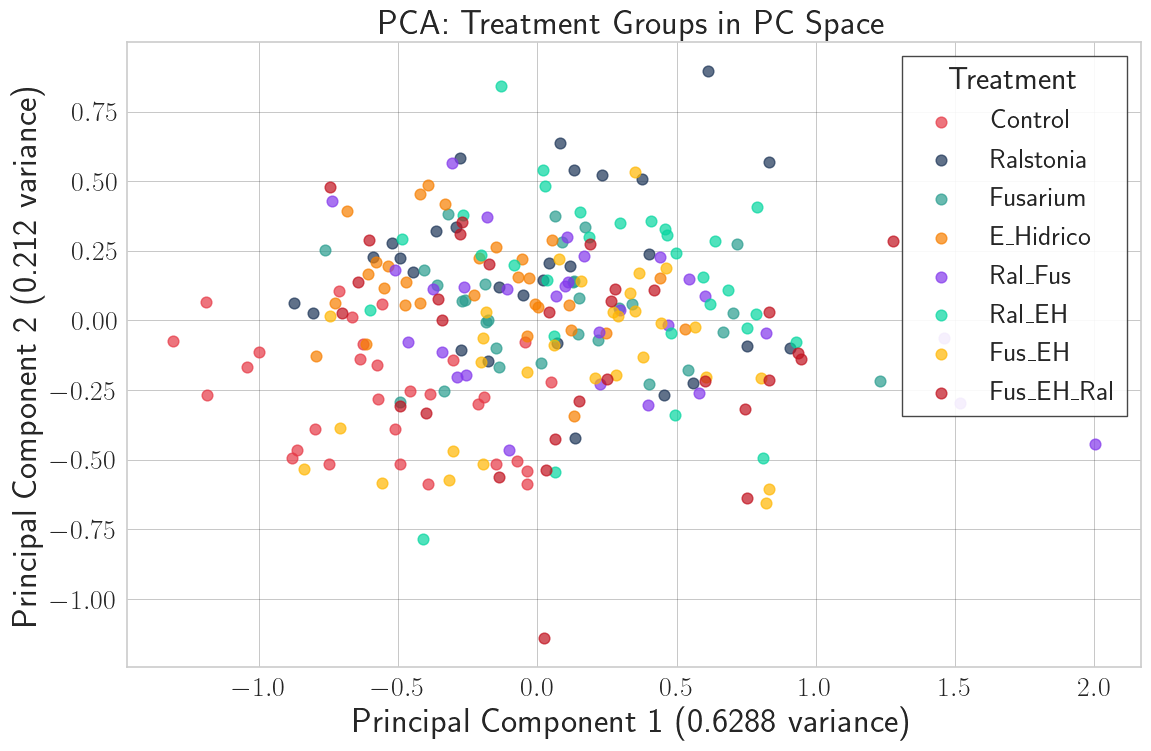

In [ ]:
pca_analysis = PCA_Analysis(df1)
pca_results = pca_analysis.PCA_2D()

Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Explained variance by PC3: 5.74%
Total explained variance: 89.82%


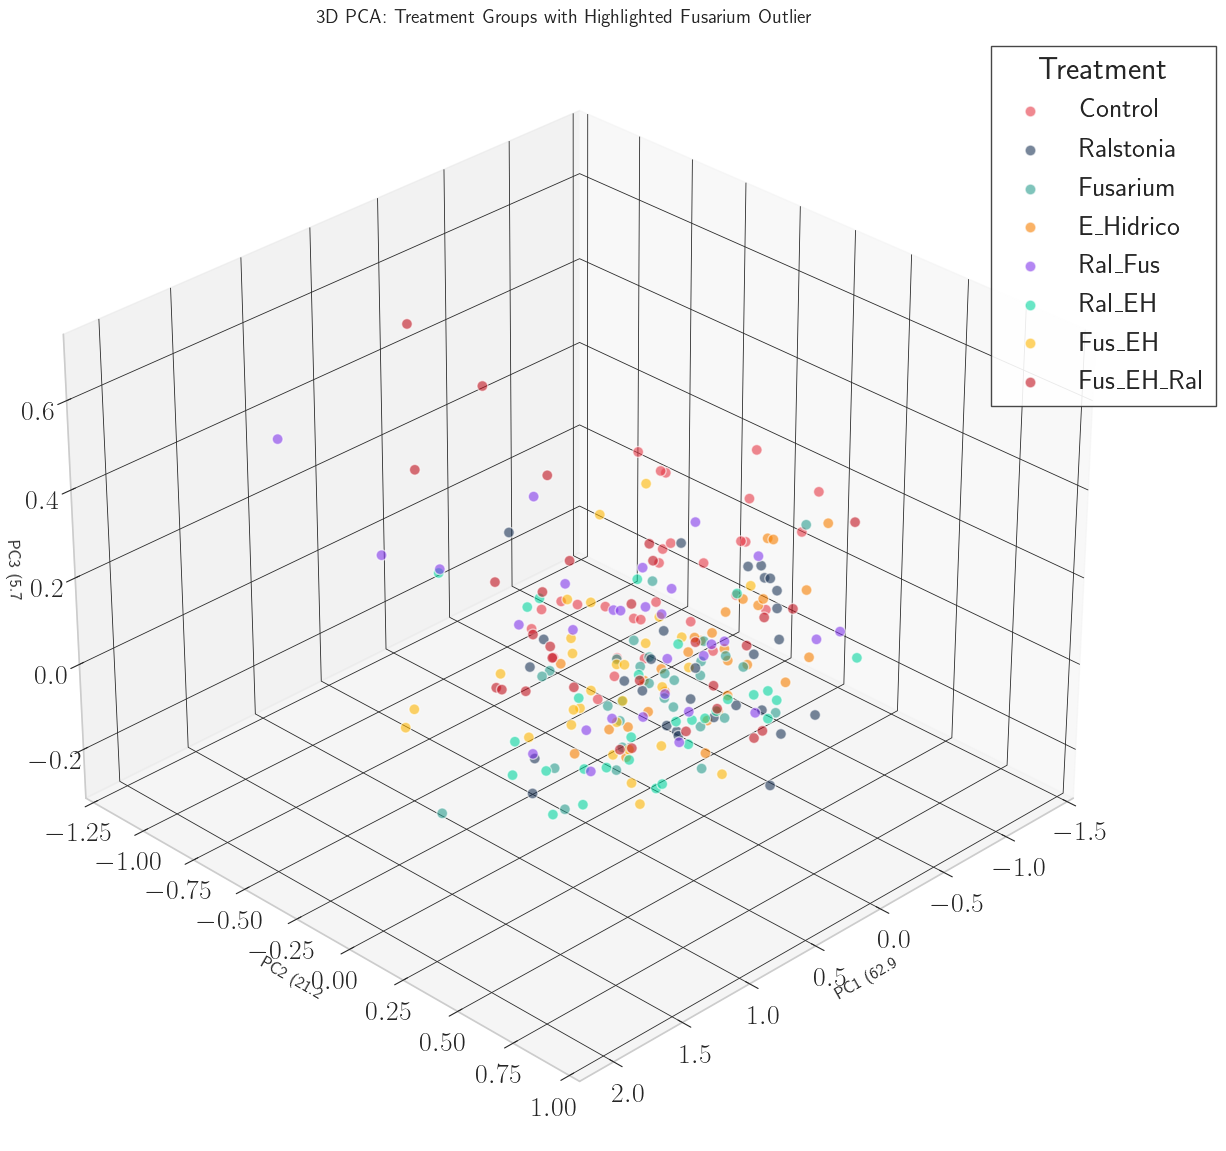

In [5]:
pca_analysis = PCA_Analysis(df1)
pca_results = pca_analysis.PCA_3D()

### Day 2

Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Total explained variance: 95.53%


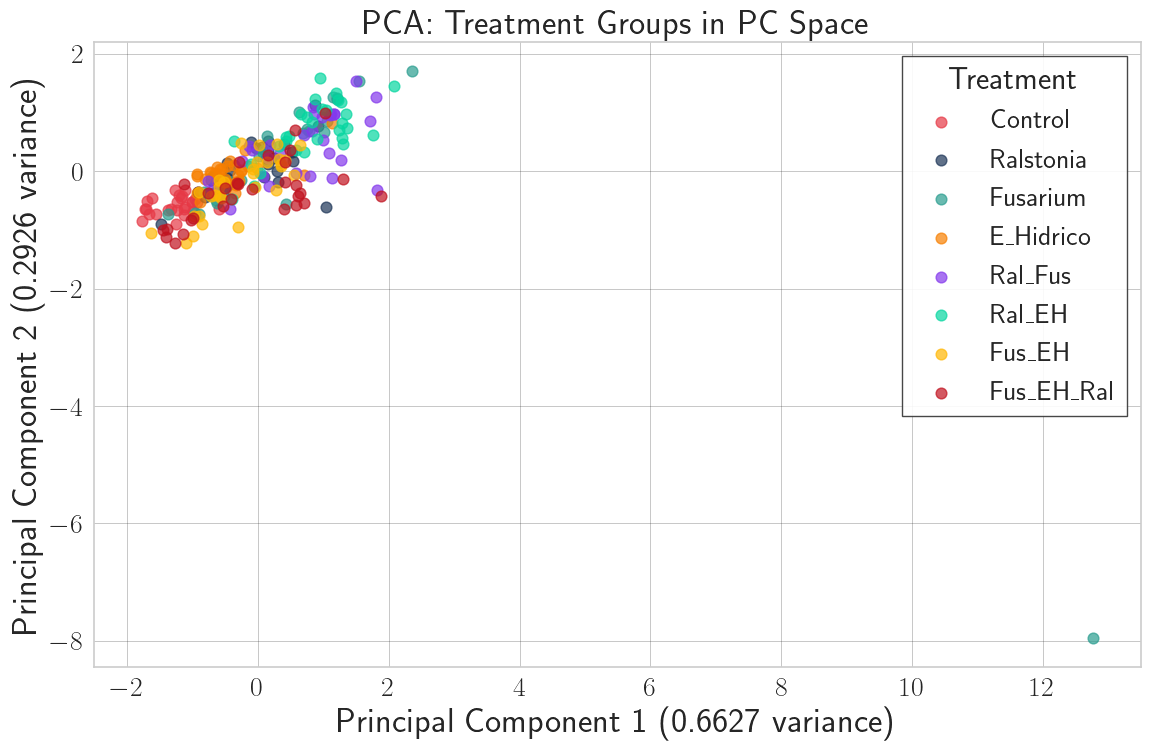

In [6]:
pca_analysis = PCA_Analysis(df2)
pca_results = pca_analysis.PCA_2D()

Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Explained variance by PC3: 2.59%
Total explained variance: 98.12%


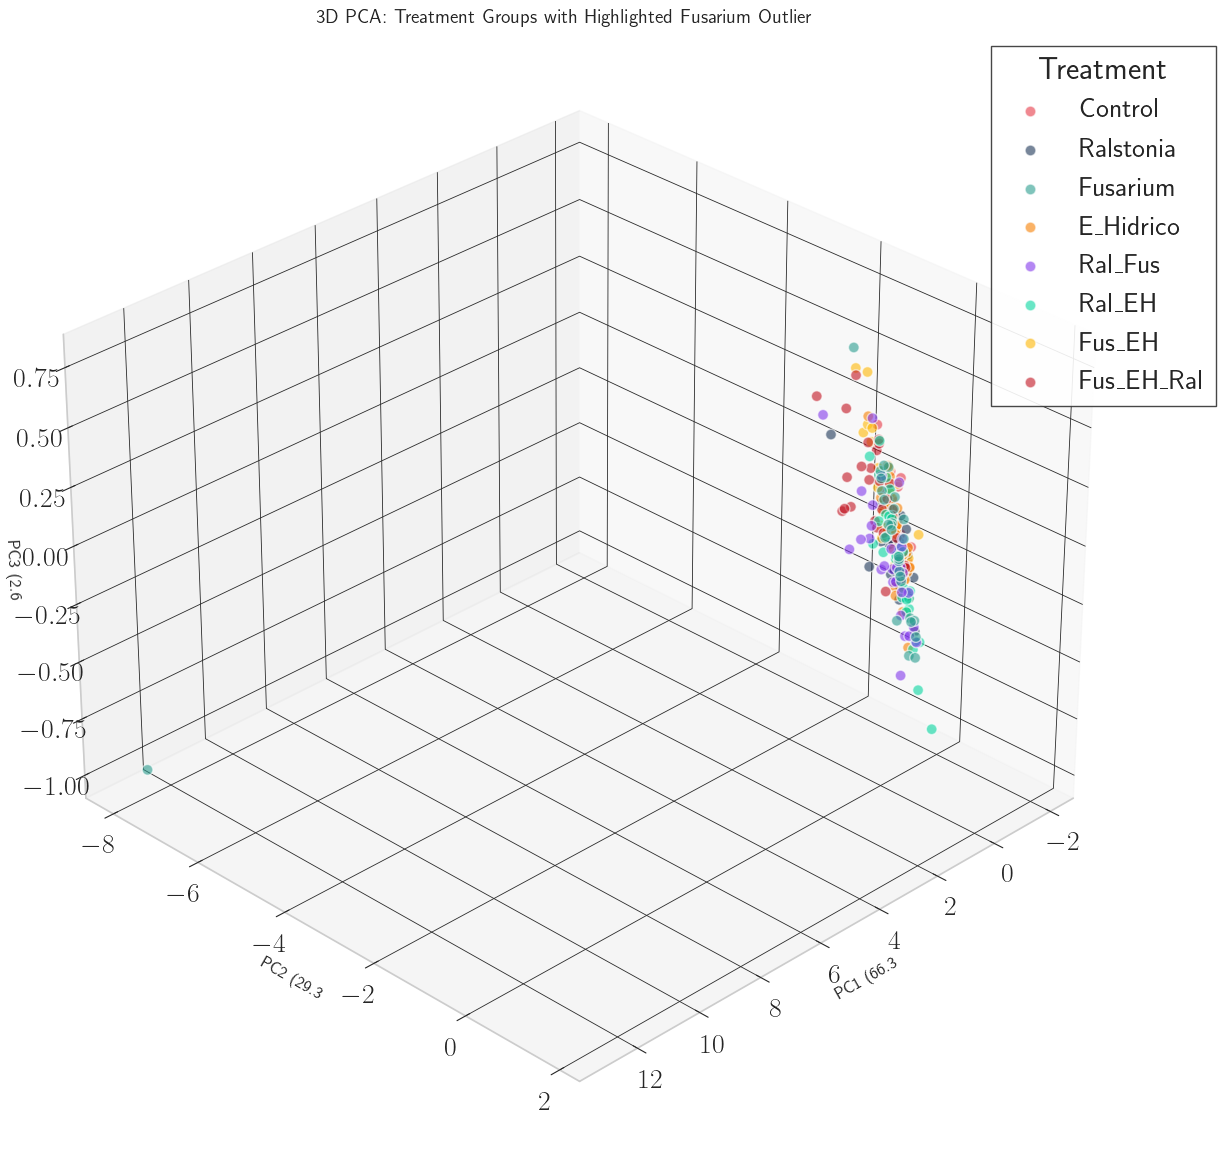

In [7]:
pca_analysis = PCA_Analysis(df2)
pca_results = pca_analysis.PCA_3D()

### Day 3

Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Total explained variance: 88.44%


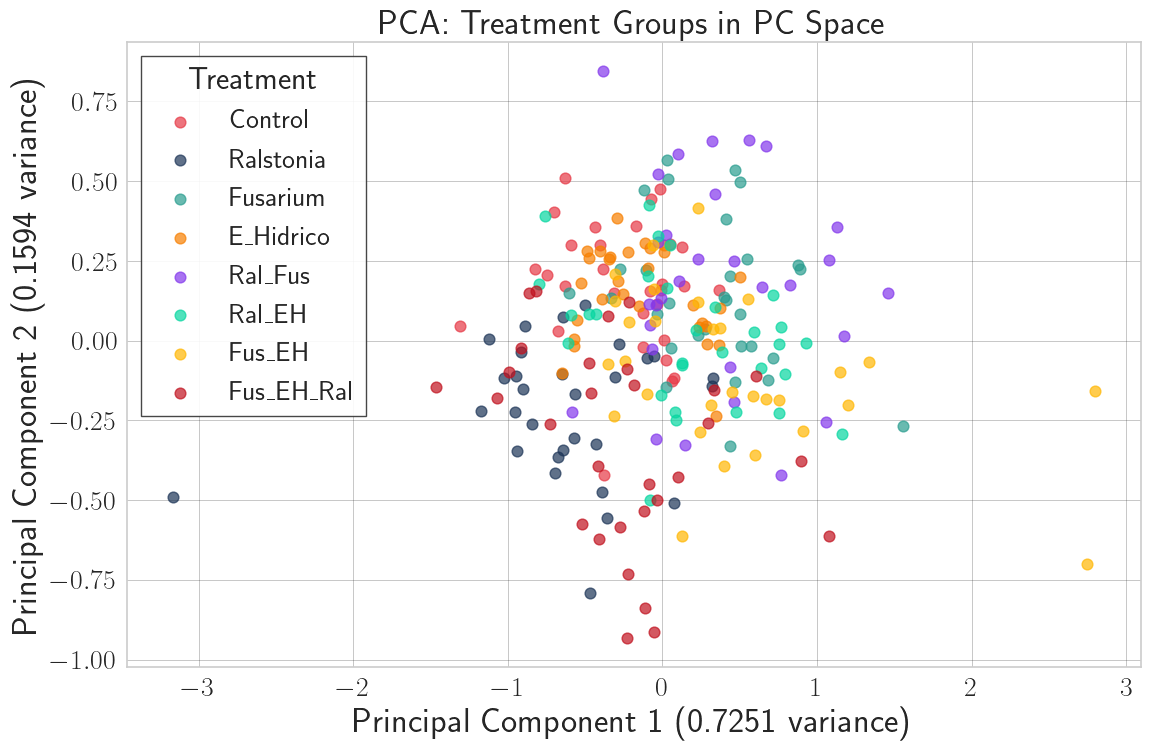

In [8]:
pca_analysis = PCA_Analysis(df3)
pca_results = pca_analysis.PCA_2D()

Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Explained variance by PC3: 4.16%
Total explained variance: 92.60%


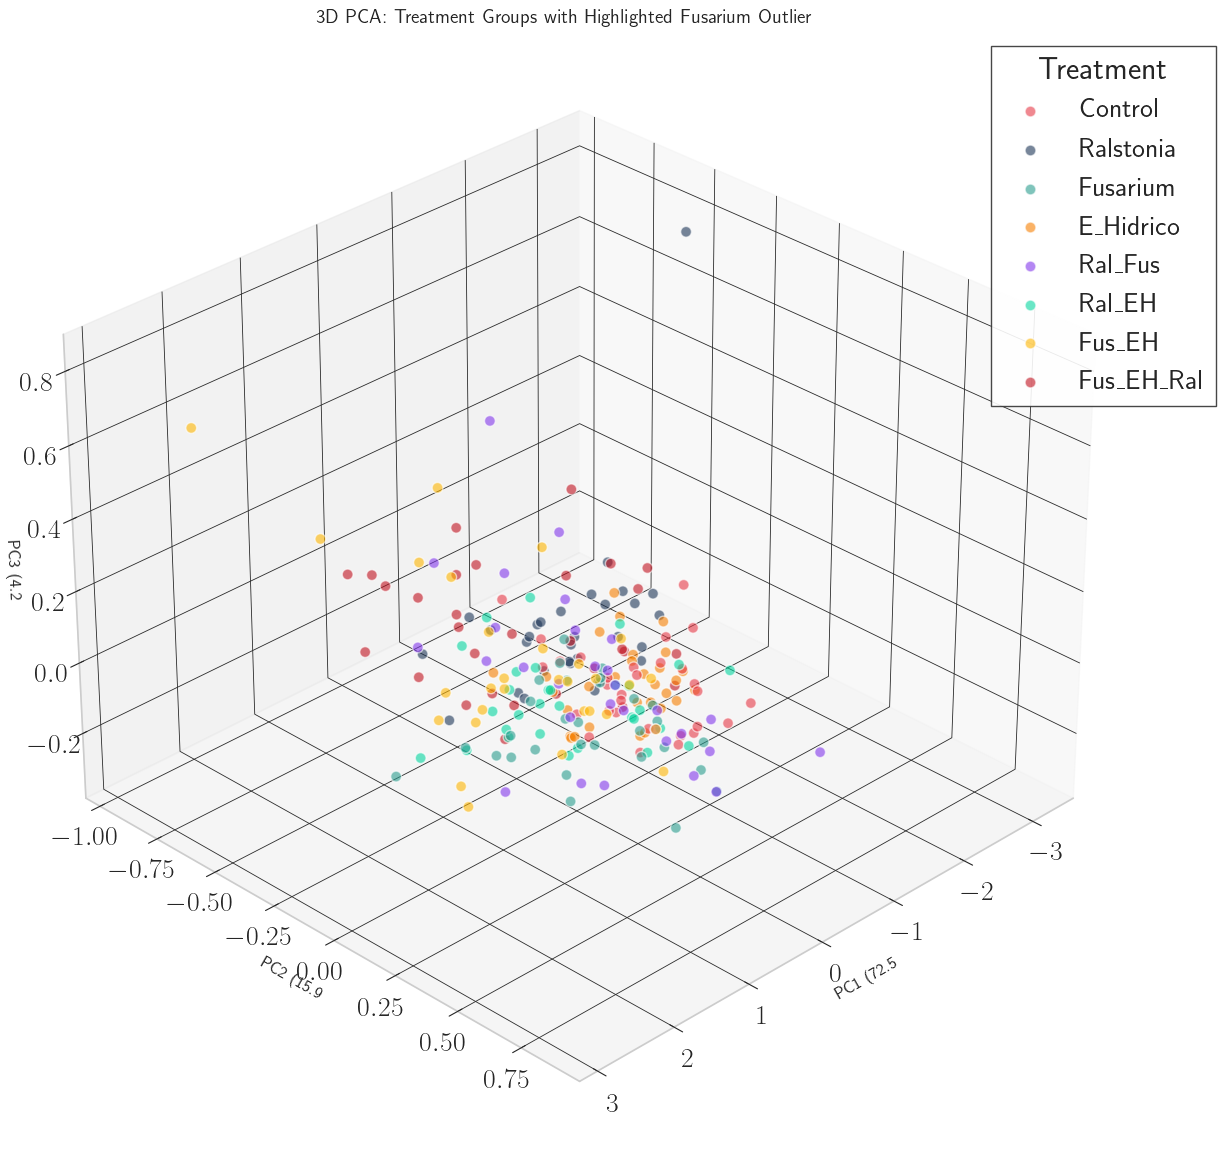

In [9]:
pca_analysis = PCA_Analysis(df3)
pca_results = pca_analysis.PCA_3D()

## PCA by treatment

### Control

--- PCA Control Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Total explained variance: 84.08%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Total explained variance: 95.53%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Total explained variance: 88.44%
---


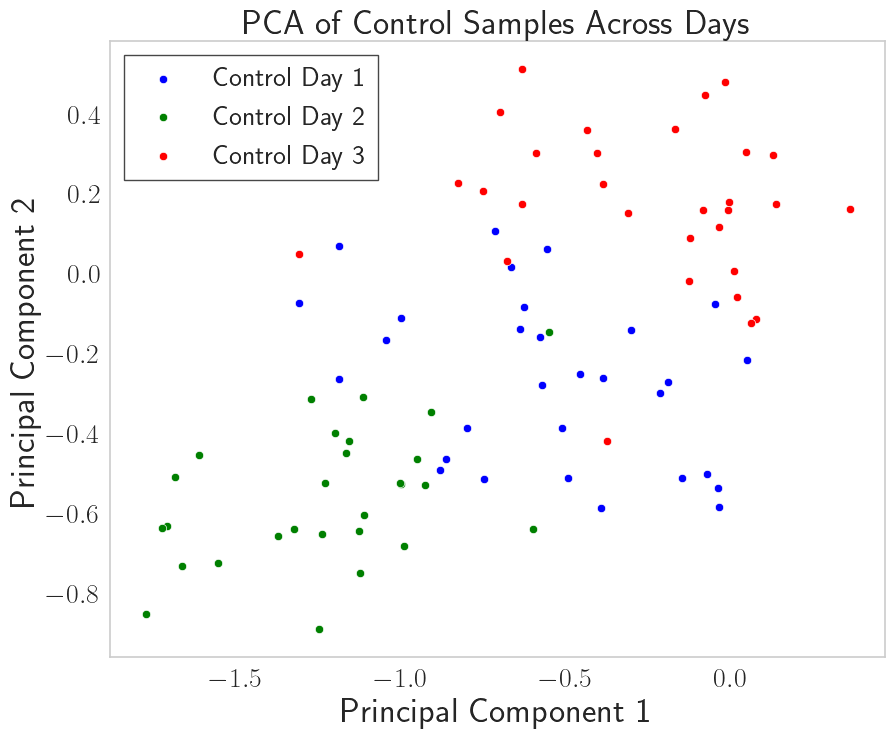

In [13]:
print('--- PCA Control Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Control']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Control']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Control']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Control Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Control Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Control Day 3', color='red')
plt.title('PCA of Control Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()


--- PCA Control Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Explained variance by PC3: 5.74%
Total explained variance: 89.82%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Explained variance by PC3: 2.59%
Total explained variance: 98.12%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Explained variance by PC3: 4.16%
Total explained variance: 92.60%
---


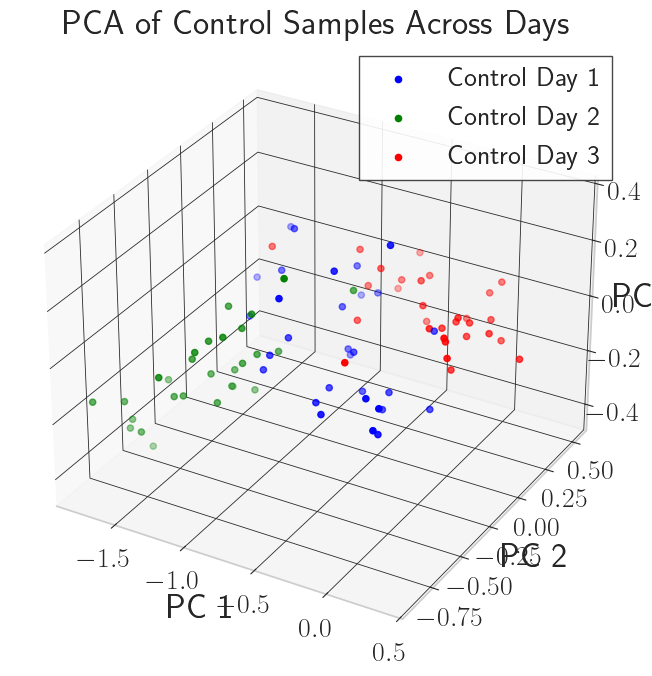

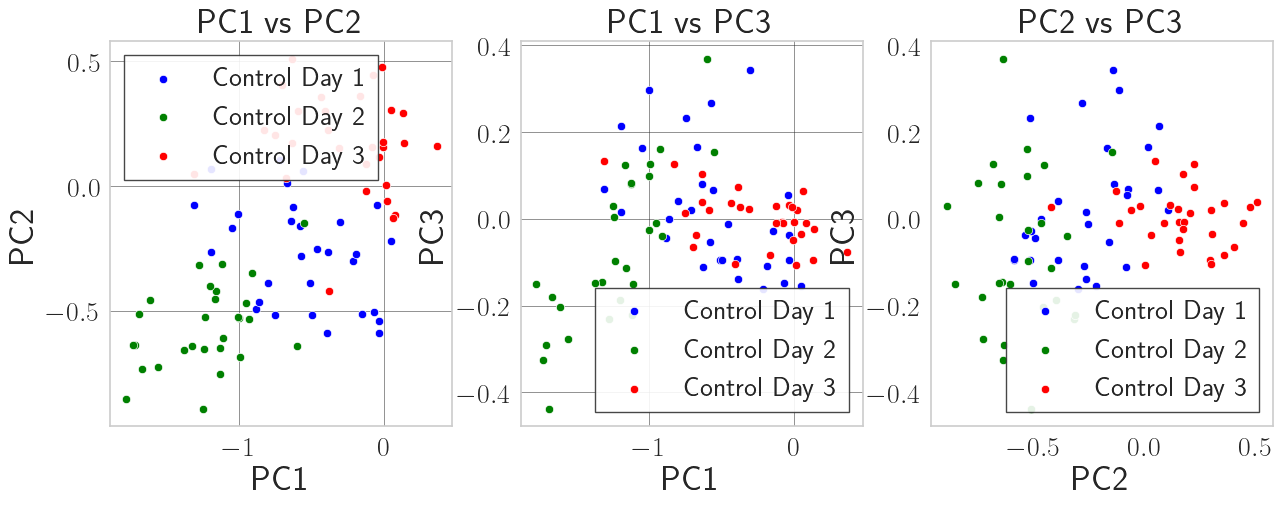

In [30]:
print('--- PCA Control Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Control']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Control']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Control']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='Control Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='Control Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='Control Day 3', color='red')
ax.set_title('PCA of Control Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Control Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Control Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Control Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='Control Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='Control Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='Control Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='Control Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='Control Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='Control Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

### Fusarium

--- PCA Fusarium Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Total explained variance: 84.08%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Total explained variance: 95.53%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Total explained variance: 88.44%
---


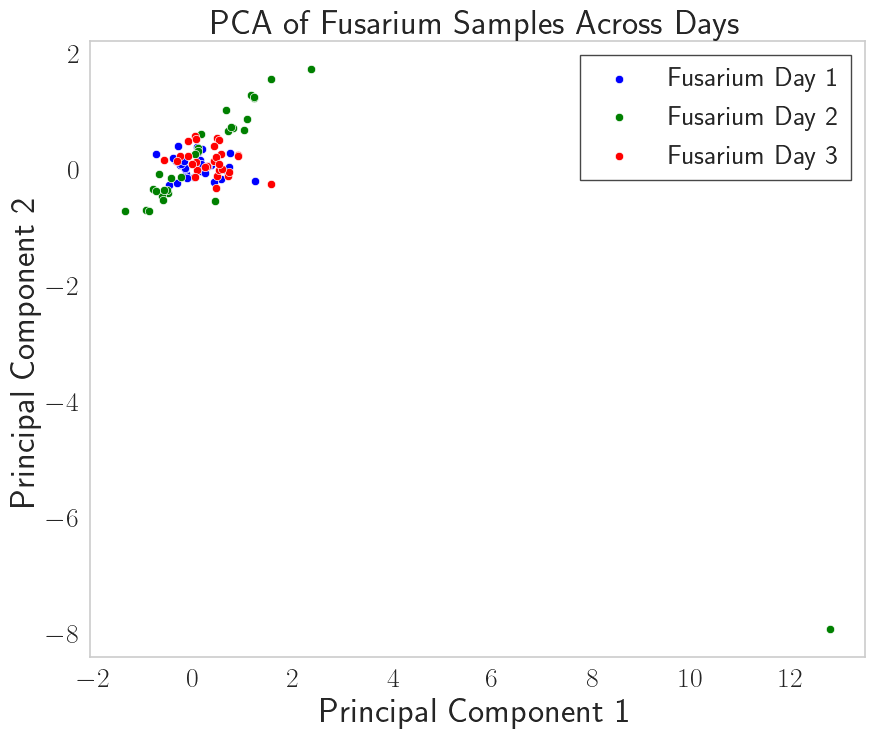

In [14]:
print('--- PCA Fusarium Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Fusarium']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Fusarium']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Fusarium']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Fusarium Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Fusarium Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Fusarium Day 3', color='red')
plt.title('PCA of Fusarium Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

--- PCA Fusarium Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Explained variance by PC3: 5.74%
Total explained variance: 89.82%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Explained variance by PC3: 2.59%
Total explained variance: 98.12%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Explained variance by PC3: 4.16%
Total explained variance: 92.60%
---


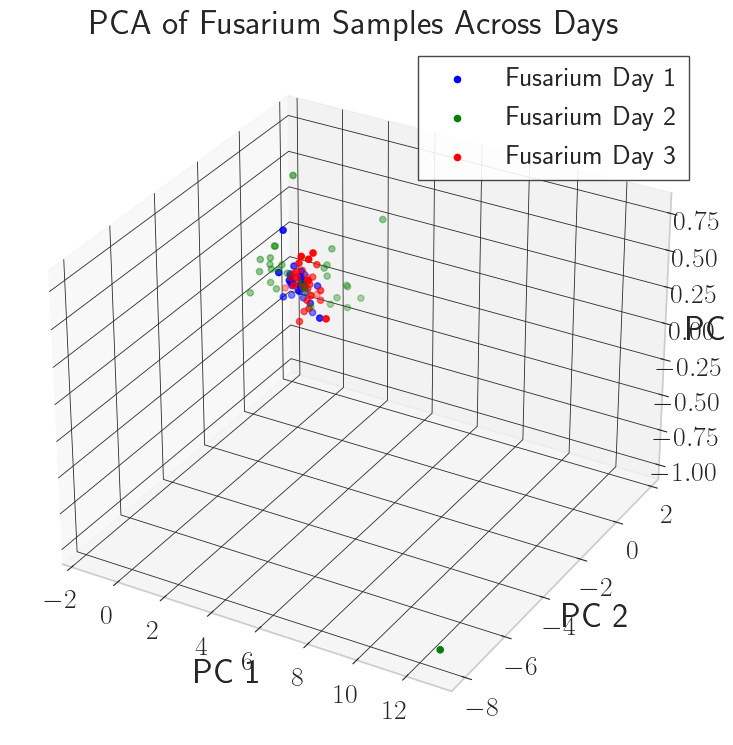

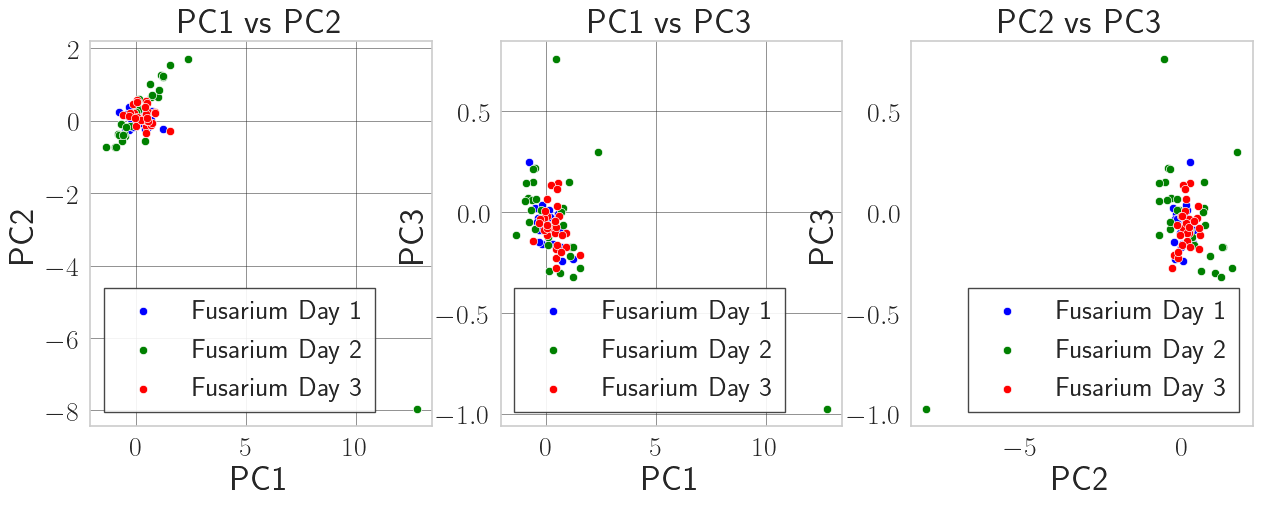

In [29]:
print('--- PCA Fusarium Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Fusarium']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Fusarium']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Fusarium']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='Fusarium Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='Fusarium Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='Fusarium Day 3', color='red')
ax.set_title('PCA of Fusarium Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Fusarium Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Fusarium Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Fusarium Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='Fusarium Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='Fusarium Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='Fusarium Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='Fusarium Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='Fusarium Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='Fusarium Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

### Ralstonia

--- PCA Ralstonia Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Total explained variance: 84.08%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Total explained variance: 95.53%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Total explained variance: 88.44%
---


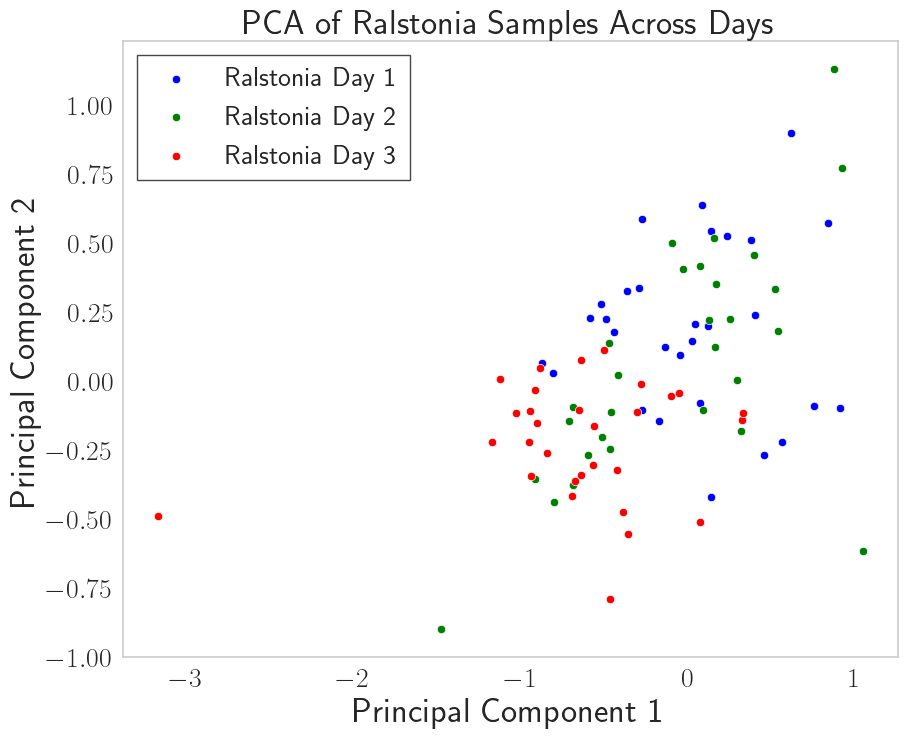

In [15]:
print('--- PCA Ralstonia Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Ralstonia']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Ralstonia']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Ralstonia']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Ralstonia Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Ralstonia Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Ralstonia Day 3', color='red')
plt.title('PCA of Ralstonia Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

--- PCA Ralstonia Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Explained variance by PC3: 5.74%
Total explained variance: 89.82%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Explained variance by PC3: 2.59%
Total explained variance: 98.12%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Explained variance by PC3: 4.16%
Total explained variance: 92.60%
---


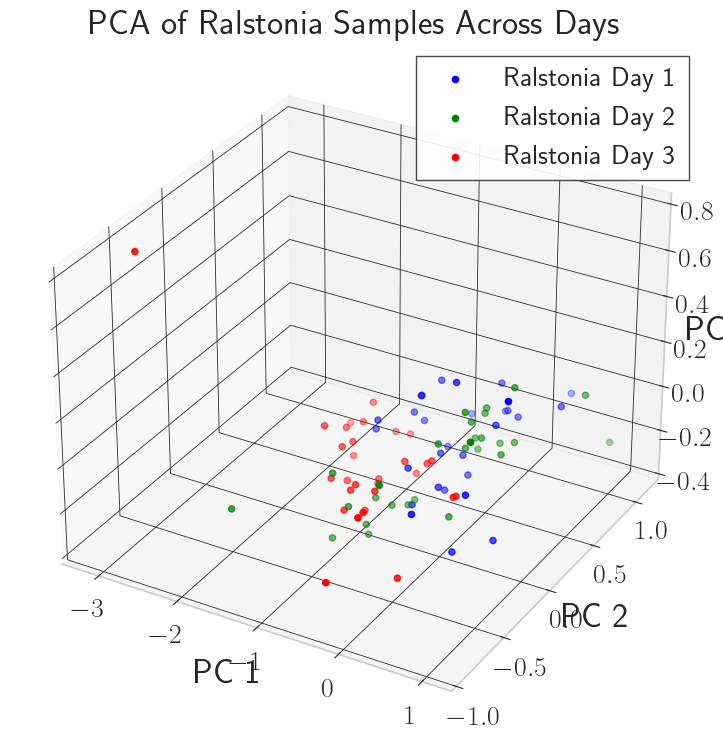

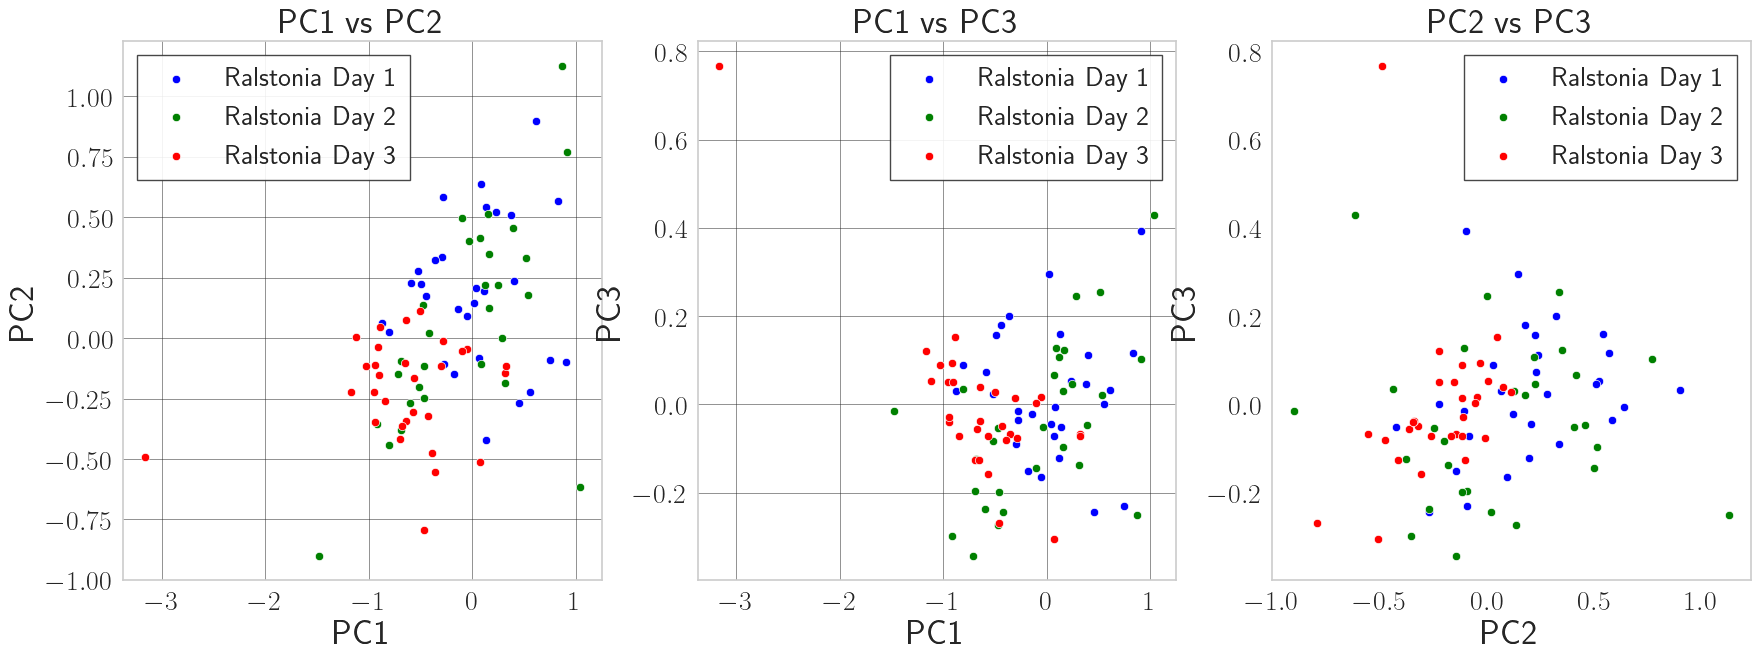

In [33]:
print('--- PCA Ralstonia Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Ralstonia']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Ralstonia']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Ralstonia']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='Ralstonia Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='Ralstonia Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='Ralstonia Day 3', color='red')
ax.set_title('PCA of Ralstonia Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Ralstonia Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Ralstonia Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Ralstonia Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='Ralstonia Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='Ralstonia Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='Ralstonia Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='Ralstonia Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='Ralstonia Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='Ralstonia Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

### Estres Hidrico

--- PCA E_Hidrico Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Total explained variance: 84.08%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Total explained variance: 95.53%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Total explained variance: 88.44%
---


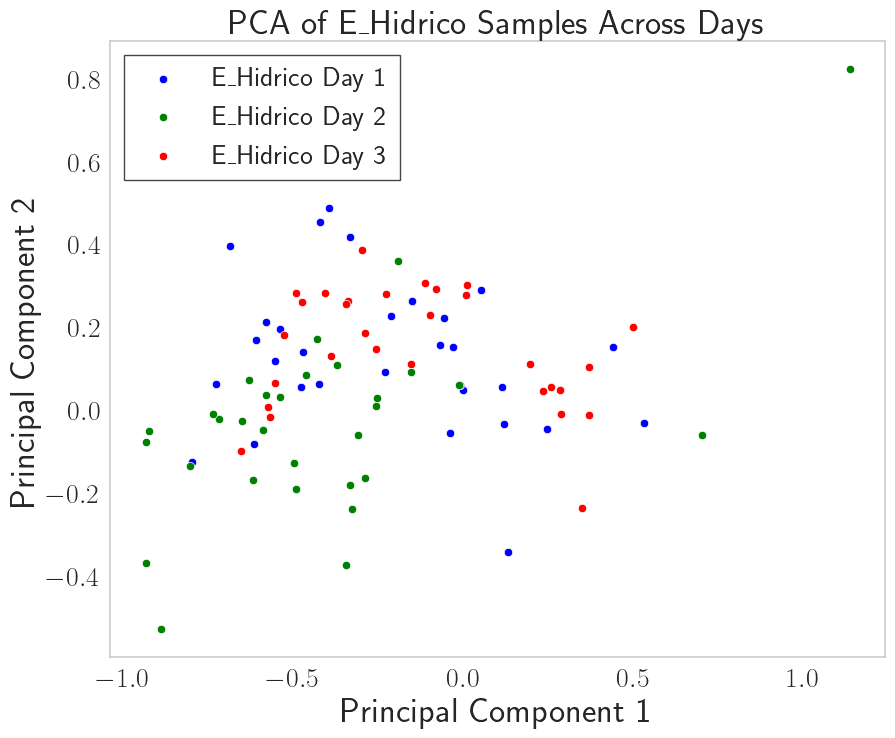

In [16]:
print('--- PCA E_Hidrico Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'E_Hidrico']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'E_Hidrico']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'E_Hidrico']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='E_Hidrico Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='E_Hidrico Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='E_Hidrico Day 3', color='red')
plt.title('PCA of E_Hidrico Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

--- PCA E_Hidrico Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Explained variance by PC3: 5.74%
Total explained variance: 89.82%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Explained variance by PC3: 2.59%
Total explained variance: 98.12%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Explained variance by PC3: 4.16%
Total explained variance: 92.60%
---


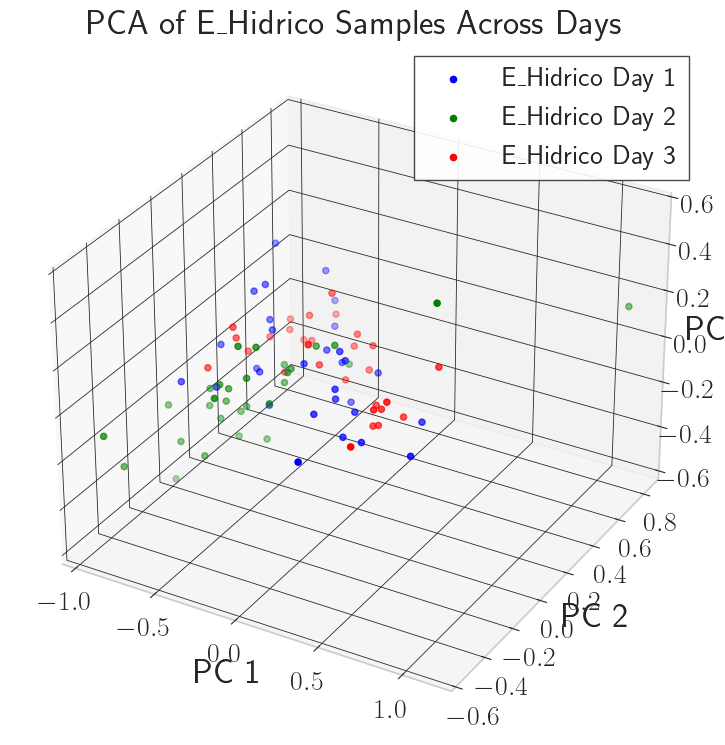

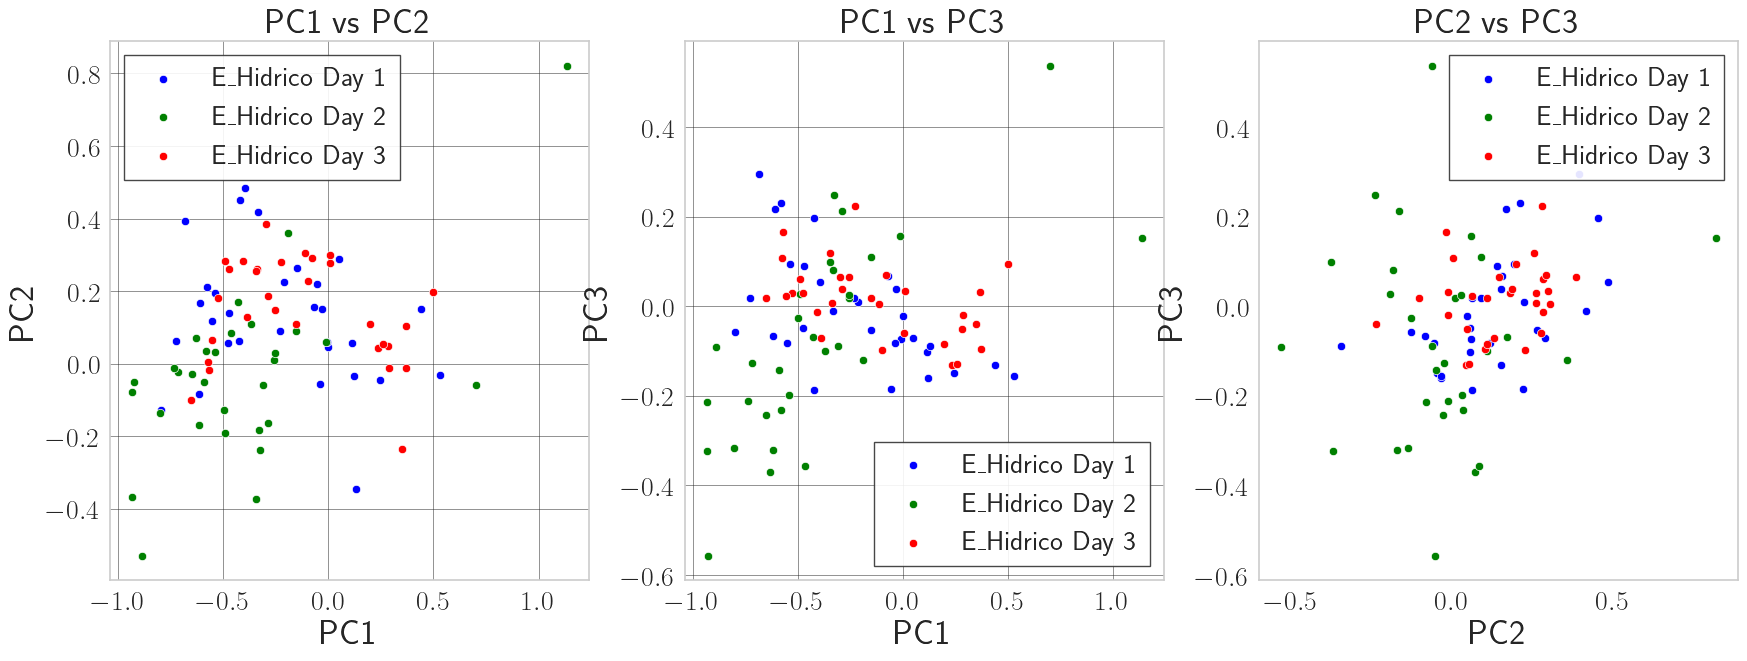

In [34]:
print('--- PCA E_Hidrico Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'E_Hidrico']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'E_Hidrico']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'E_Hidrico']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='E_Hidrico Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='E_Hidrico Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='E_Hidrico Day 3', color='red')
ax.set_title('PCA of E_Hidrico Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='E_Hidrico Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='E_Hidrico Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='E_Hidrico Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='E_Hidrico Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='E_Hidrico Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='E_Hidrico Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='E_Hidrico Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='E_Hidrico Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='E_Hidrico Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

### Ral_EH

--- PCA Ral_EH Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Total explained variance: 84.08%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Total explained variance: 95.53%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Total explained variance: 88.44%
---


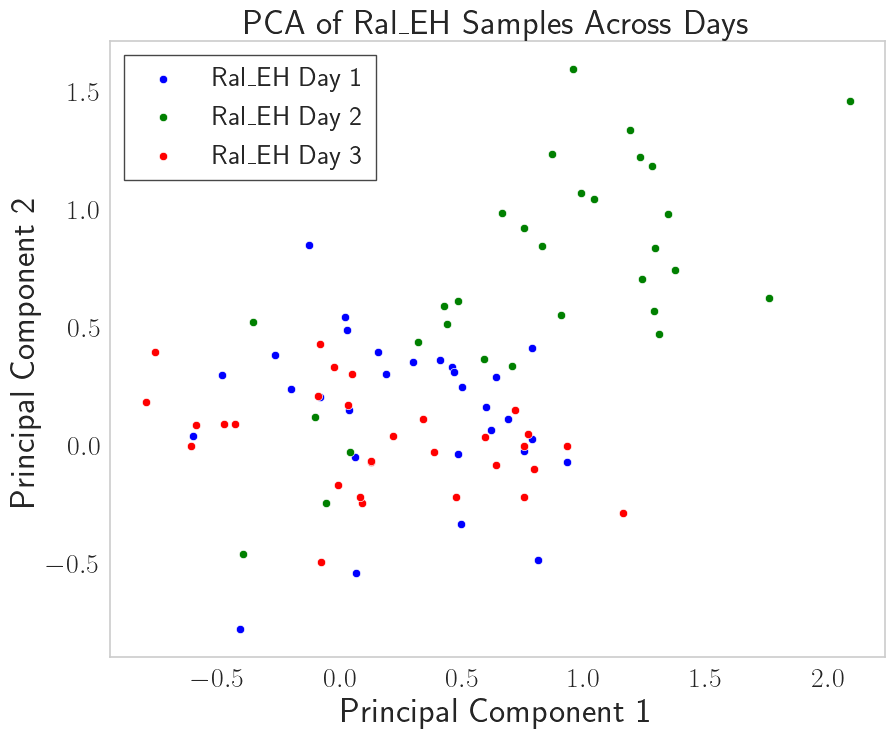

In [17]:
print('--- PCA Ral_EH Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Ral_EH']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Ral_EH']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Ral_EH']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Ral_EH Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Ral_EH Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Ral_EH Day 3', color='red')
plt.title('PCA of Ral_EH Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

### Ral_Fus

--- PCA Ral_Fus Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Total explained variance: 84.08%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Total explained variance: 95.53%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Total explained variance: 88.44%
---


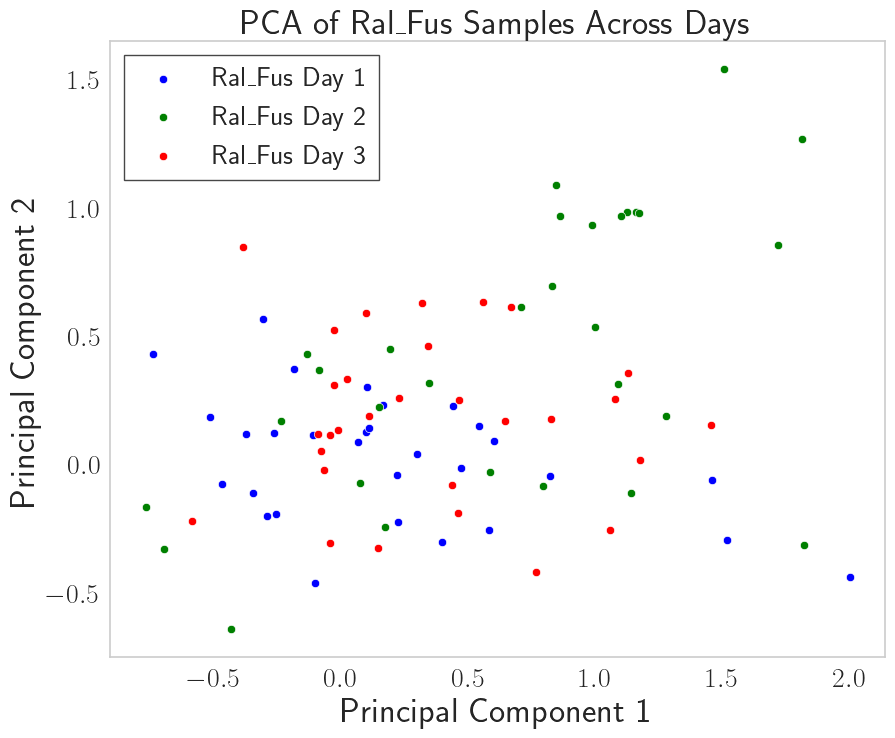

In [18]:
print('--- PCA Ral_Fus Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Ral_Fus']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Ral_Fus']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Ral_Fus']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Ral_Fus Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Ral_Fus Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Ral_Fus Day 3', color='red')
plt.title('PCA of Ral_Fus Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

### Fus_EH_Ral 

--- PCA Fus_EH_Ral Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Total explained variance: 84.08%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Total explained variance: 95.53%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Total explained variance: 88.44%
---


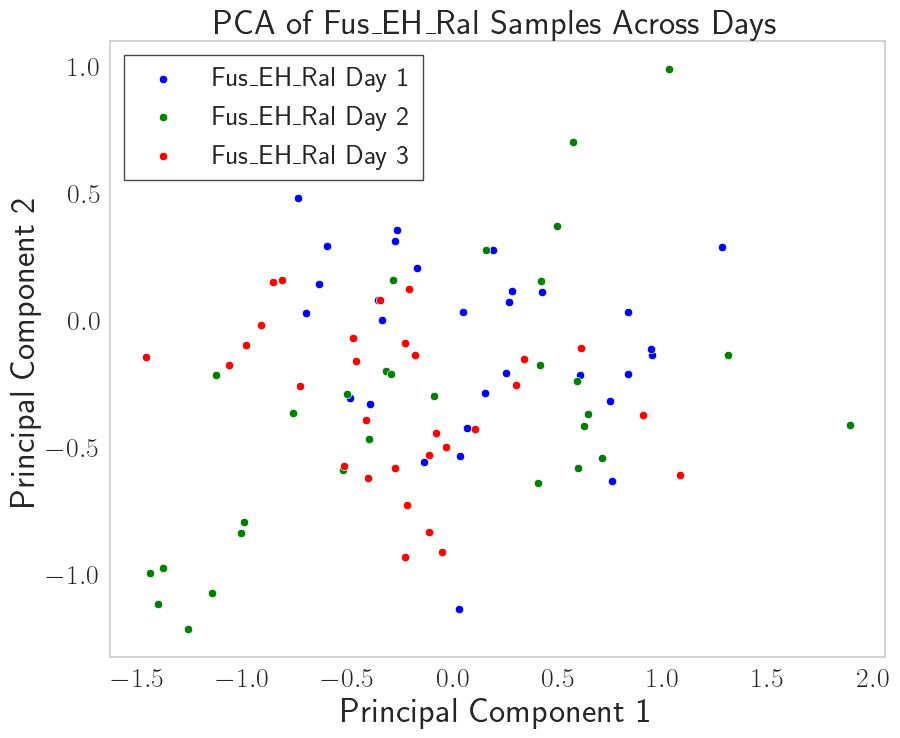

In [19]:
print('--- PCA Fus_EH_Ral Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Fus_EH_Ral']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Fus_EH_Ral']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Fus_EH_Ral']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Fus_EH_Ral Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Fus_EH_Ral Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Fus_EH_Ral Day 3', color='red')
plt.title('PCA of Fus_EH_Ral Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

### Fus_EH

--- PCA Fus_EH Samples Across Days ---
---
PCA df1 
Explained variance by PC1: 62.88%
Explained variance by PC2: 21.20%
Total explained variance: 84.08%
---
PCA df2 
Explained variance by PC1: 66.27%
Explained variance by PC2: 29.26%
Total explained variance: 95.53%
---
PCA df3 
Explained variance by PC1: 72.51%
Explained variance by PC2: 15.94%
Total explained variance: 88.44%
---


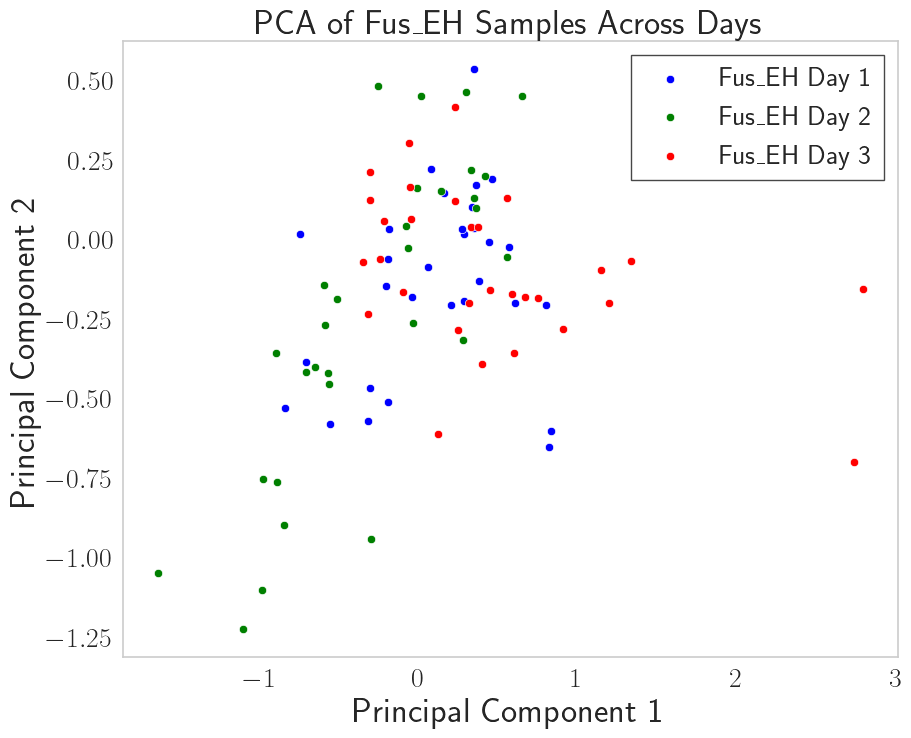

In [20]:
print('--- PCA Fus_EH Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Fus_EH']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Fus_EH']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Fus_EH']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Fus_EH Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Fus_EH Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Fus_EH Day 3', color='red')
plt.title('PCA of Fus_EH Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()